<b>¡Hola Bruno!</b>

Mi nombre es Alejandro Abia y tengo el gusto de revisar tu proyecto.

A continuación, encontrarás mis comentarios en celdas pintadas de tres colores (verde, amarillo y rojo), a manera de semáforo. Por favor, <b>no las borres ni muevas de posición</b> mientras dure el proceso de revisión.

<div class="alert alert-block alert-success">
<b>Éxito</b> <a class="tocSkip"></a>
En celdas verdes encontrarás comentarios en relación a tus aciertos y fortalezas.
</div>
<div class="alert alert-block alert-warning">
<b>Atención</b> <a class="tocSkip"></a>
Utilizaré el color amarillo para llamar tu atención, expresar algo importante o compartirte alguna idea de valor.
</div>
<div class="alert alert-block alert-danger">
<b>A resolver</b> <a class="tocSkip"></a>
En rojo emitiré aquellos puntos que podrían impedir que el proyecto se ejecute correctamente. No son errores, sino oportunidades importantes de mejora.
</div>
<div class="alert alert-block alert-info">
<b>Comentario estudiante</b><a class="tocSkip"></a>
Si durante la revisión deseas dejarme algún comentario, por favor utiliza celdas azules como esta.
</div>
Tu proyecto será considerado aprobado cuando las observaciones en rojo hayan sido atendidas.
¡Empecemos!

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
print(df_reviews.head())
print()
print(df_reviews.info())


      tconst title_type primary_title original_title  start_year end_year  \
0  tt0068152      movie             $              $        1971       \N   
1  tt0068152      movie             $              $        1971       \N   
2  tt0313150      short          '15'           '15'        2002       \N   
3  tt0313150      short          '15'           '15'        2002       \N   
4  tt0313150      short          '15'           '15'        2002       \N   

  runtime_minutes  is_adult              genres  average_rating  votes  \
0             121         0  Comedy,Crime,Drama             6.3   2218   
1             121         0  Comedy,Crime,Drama             6.3   2218   
2              25         0  Comedy,Drama,Short             6.3    184   
3              25         0  Comedy,Drama,Short             6.3    184   
4              25         0  Comedy,Drama,Short             6.3    184   

                                              review  rating   sp  pos  \
0  The pakage impl

<div class="alert alert-block alert-success">
<b>Celda [4]</b> <a class="tocSkip"></a><br>
Excelente inicio con la carga y visualización preliminar de los datos. Mostrar las primeras entradas y la información del DataFrame es una práctica recomendable para entender la estructura y tipos de datos con los que trabajarás.
</div>

Hemos cargado exitosamente el conjunto de datos de **47,331 reseñas de películas** utilizando la biblioteca Pandas. El archivo, al ser separado por tabuladores (`.tsv`), requirió especificar el separador para su correcta lectura. El DataFrame resultante contiene 17 columnas, de las cuales hemos identificado tres como cruciales para nuestro objetivo: `review`, que contiene el texto a clasificar; `pos`, nuestra variable objetivo numérica (`1` para positivo, `0` para negativo); y `ds_part`, que divide los datos en conjuntos de **entrenamiento y prueba**.

Un primer vistazo a la calidad de los datos es muy positivo. Las columnas `review` y `pos`, que son el corazón de nuestro proyecto, no tienen valores nulos. Aunque existen un par de datos faltantes en columnas secundarias como `votes` y `average_rating`, su cantidad es insignificante y no afectará nuestro modelo de clasificación de texto. Con los datos cargados y su estructura principal entendida, se hará un análisis rápido de datos duplicados y uno de consistencia en las columnas, principalmente para sp y pos, para evaluar si el número 0 siempre corresponde con neg (negativo) y 1 con valores positivos. 

In [5]:
# Contar cuántas reseñas de texto están duplicadas
num_duplicados = df_reviews.duplicated(subset=['review']).sum()

print(f"Número de reseñas duplicadas: {num_duplicados}")

# Verificar los valores únicos en la columna objetivo 'pos'
print(f"Valores únicos en la columna 'pos': {df_reviews['pos'].unique()}")

# Verificar los valores únicos en la columna de partición 'ds_part'
print(f"Valores únicos en la columna 'ds_part': {df_reviews['ds_part'].unique()}")

# Crear una tabla de contingencia para ver la relación entre 'sp' y 'pos'
print("Tabla de consistencia entre 'sp' y 'pos':")
print(pd.crosstab(df_reviews['sp'], df_reviews['pos']))

Número de reseñas duplicadas: 91
Valores únicos en la columna 'pos': [0 1]
Valores únicos en la columna 'ds_part': ['train' 'test']
Tabla de consistencia entre 'sp' y 'pos':
pos      0      1
sp               
neg  23715      0
pos      0  23616


<div class="alert alert-block alert-success">
<b>Celda [5]</b> <a class="tocSkip"></a><br>
Has identificado correctamente reseñas duplicadas, lo cual es crucial para la calidad del análisis. Sin embargo, sería útil realizar un análisis más profundo sobre por qué se duplican y si hay patrones comunes entre ellas que puedan indicar problemas subyacentes en la recopilación de datos.
</div>

In [17]:
# Guardamos las dimensiones originales para verificar después
print(f"Tamaño original del DataFrame: {df_reviews.shape}")

# Eliminamos las filas donde el texto de 'review' está duplicado, conservando la primera aparición
df_reviews.drop_duplicates(subset=['review'], keep='first', inplace=True)

# Verificamos el nuevo tamaño del DataFrame
print(f"Nuevo tamaño del DataFrame después de eliminar duplicados: {df_reviews.shape}")

# Opcional: Re-calculamos los duplicados para confirmar que ya no hay
print(f"Número de reseñas duplicadas ahora: {df_reviews.duplicated(subset=['review']).sum()}")

Tamaño original del DataFrame: (47331, 18)
Nuevo tamaño del DataFrame después de eliminar duplicados: (47240, 18)
Número de reseñas duplicadas ahora: 0


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

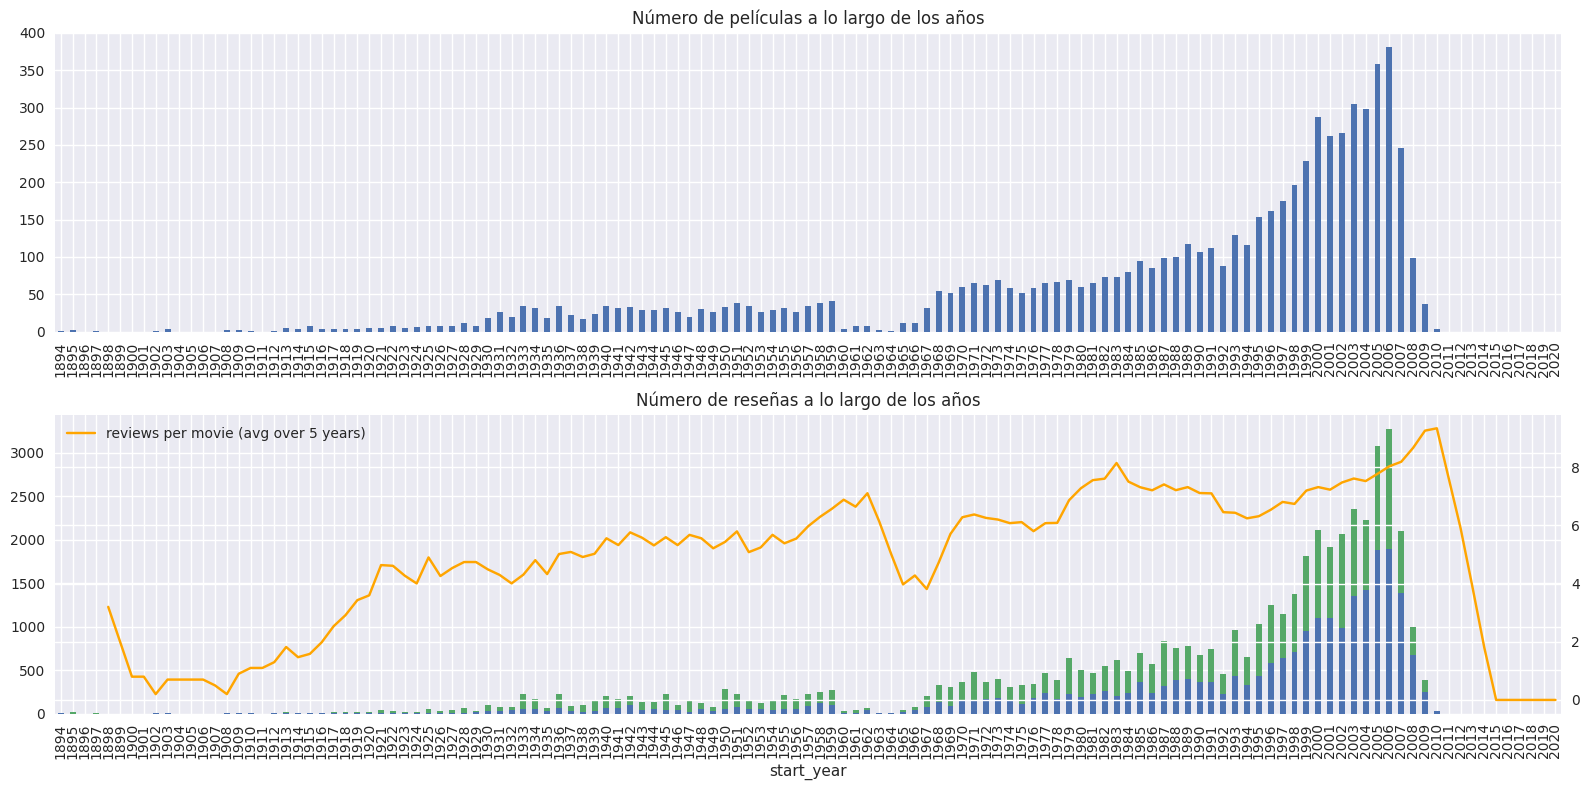

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

<div class="alert alert-block alert-success">
<b>Celda [6]</b> <a class="tocSkip"></a><br>
Los gráficos de barras y el uso de un eje secundario para mostrar diferentes escalas son técnicas efectivas para comparar tendencias a lo largo del tiempo. Esto ayuda a visualizar la evolución del número de películas y reseñas, proporcionando un contexto valioso para el análisis posterior.
</div>

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

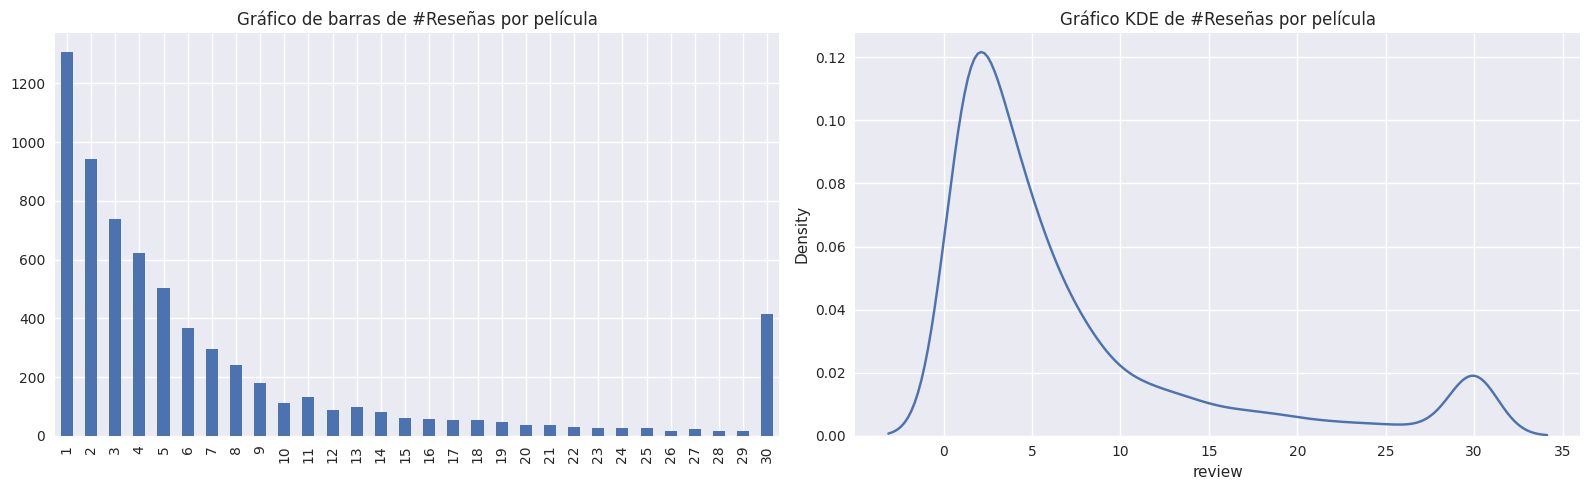

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

<div class="alert alert-block alert-success">
<b>Celda [7]</b> <a class="tocSkip"></a><br>
Los gráficos proporcionados son útiles. Podrías considerar agregar anotaciones o líneas de tendencia para facilitar la interpretación visual de los datos. Esto puede ayudar a identificar rápidamente patrones o anomalías.<br><br><pre><code>ax.axhline(df_reviews['review'].count().mean(), color='red', linestyle='--')  # Añadir línea de tendencia</code></pre>
</div>

Nuestro análisis exploratorio revela dos características clave del conjunto de datos. Primero, la colección de reseñas está fuertemente concentrada en películas modernas, con un notorio incremento a partir del año 2000. Más importante aún para nuestro objetivo, el análisis de sentimiento muestra que el conjunto de datos está **extremadamente bien balanceado**, con una proporción casi perfecta de 50/50 entre reseñas positivas y negativas. Esta paridad es ideal para entrenar un modelo de clasificación robusto y nos permite confiar en la métrica F1 como principal evaluador de rendimiento.

Adicionalmente, hemos observado que la distribución de reseñas por película es desigual. La gran mayoría de las películas en el dataset cuentan con muy pocas reseñas (entre 1 y 5), mientras que un grupo más pequeño y distinto tiene un número considerablemente mayor (alrededor de 30). Si bien esta es una característica interesante de la composición de los datos, no impacta directamente en nuestra tarea de clasificar el sentimiento de cada reseña individual. La conclusión principal y más favorable es el excelente balance de clases que servirá como una base sólida para el modelado.

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

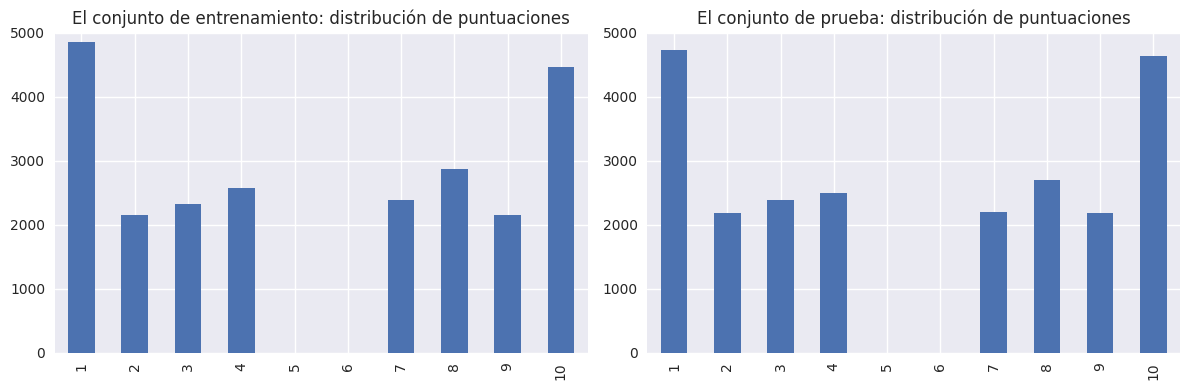

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

<div class="alert alert-block alert-success">
<b>Celda [9]</b> <a class="tocSkip"></a><br>
Buena práctica al verificar la distribución de las puntuaciones en los conjuntos de entrenamiento y prueba. Asegurarte de que las distribuciones son similares puede prevenir sesgos en el modelo de aprendizaje automático.
</div>

Los resultados numéricos confirman nuestra conclusión anterior: el conjunto de datos está **casi perfectamente balanceado**, con 23,715 reseñas negativas (`0`) y 23,616 positivas (`1`). Esto constituye una base excelente y sólida para el entrenamiento del modelo.

Los nuevos gráficos muestran la distribución de las puntuaciones de estrellas (de 1 a 10) tanto para el conjunto de entrenamiento como para el de prueba. Observamos una distribución en forma de "U" en ambos conjuntos, con una gran cantidad de reseñas en los extremos (puntuaciones de 1 y 10) y una ausencia de puntuaciones neutrales (5 y 6). Lo más importante es que **la distribución de puntuaciones es prácticamente idéntica en el conjunto de entrenamiento y en el de prueba**. Esto es una señal muy positiva, ya que indica que el conjunto de prueba es una muestra representativa de los datos de entrenamiento, lo que nos da confianza en que la evaluación de nuestro modelo será fiable.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


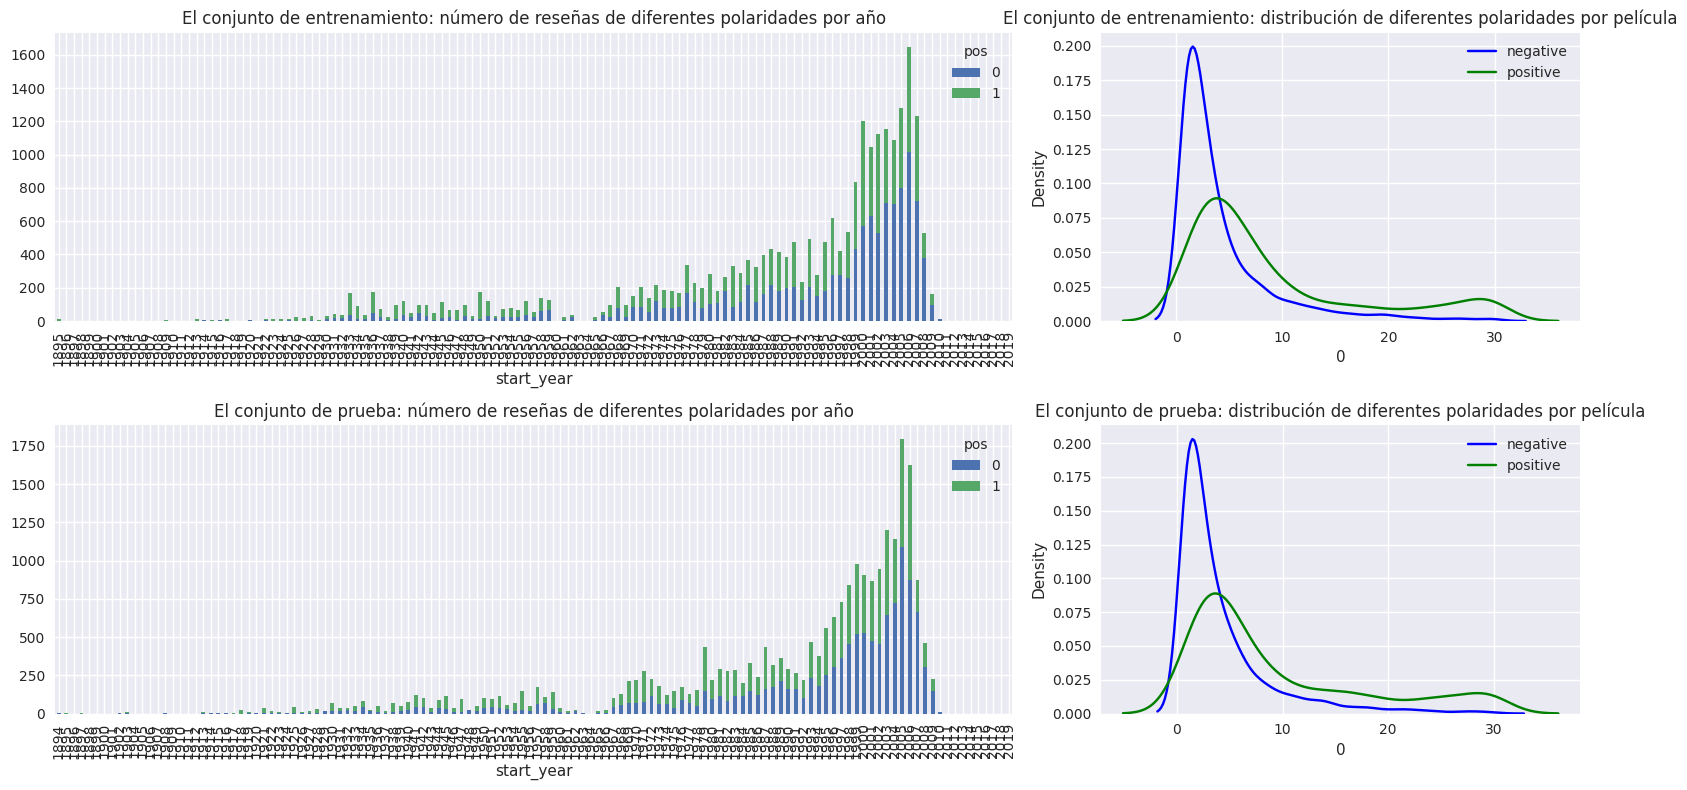

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

<div class="alert alert-block alert-success">
<b>Celda [10]</b> <a class="tocSkip"></a><br>
Has realizado una exploración visual interesante sobre la polaridad de las reseñas a lo largo del tiempo. 
</div>

Este análisis final compara directamente las características de los conjuntos de datos de entrenamiento y prueba. Los gráficos de la izquierda (barras apiladas por año) confirman visualmente que el excelente balance de clases (50/50 entre reseñas positivas y negativas) se mantiene de forma consistente a través de los años tanto en el conjunto de entrenamiento como en el de prueba.

Los gráficos de la derecha (curvas de densidad KDE) van un paso más allá, mostrando la distribución del número de reseñas positivas vs. negativas por película. Lo más importante de todo este análisis es la conclusión final: **las distribuciones en el conjunto de prueba son prácticamente idénticas a las del conjunto de entrenamiento**. Esta similitud es el sello de un conjunto de datos bien dividido y es una noticia fantástica para el modelado. Nos da una alta confianza en que el rendimiento que midamos en nuestro conjunto de prueba será un reflejo fiel de cómo funcionaría el modelo en datos nuevos. 

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [11]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<div class="alert alert-block alert-success">
<b>Celda [11]</b> <a class="tocSkip"></a><br>
Excelente implementación de métricas de evaluación para modelos de clasificación. Utilizar múltiples métricas como F1, ROC AUC y PRC es crucial para obtener una visión holística del rendimiento del modelo.
</div>

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [18]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True)# <escribe tu código aquí>

<div class="alert alert-block alert-warning">
<b>Celda [18]</b> <a class="tocSkip"></a><br>
Mientras que la normalización del texto es un paso crucial, considera explicar más sobre por qué eliges eliminar ciertos caracteres y cómo esto podría afectar el análisis de sentimientos. Además, podrías explorar el uso de expresiones regulares más complejas para una limpieza más eficaz.<br><br><pre><code>df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)  # Incluir números y simplificar la expresión regular</code></pre>
</div>

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [19]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23757, 18)
(23483, 18)


## Trabajar con modelos

### Modelo 0 - Constante

Resultados para el Dummy Classifier:
           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


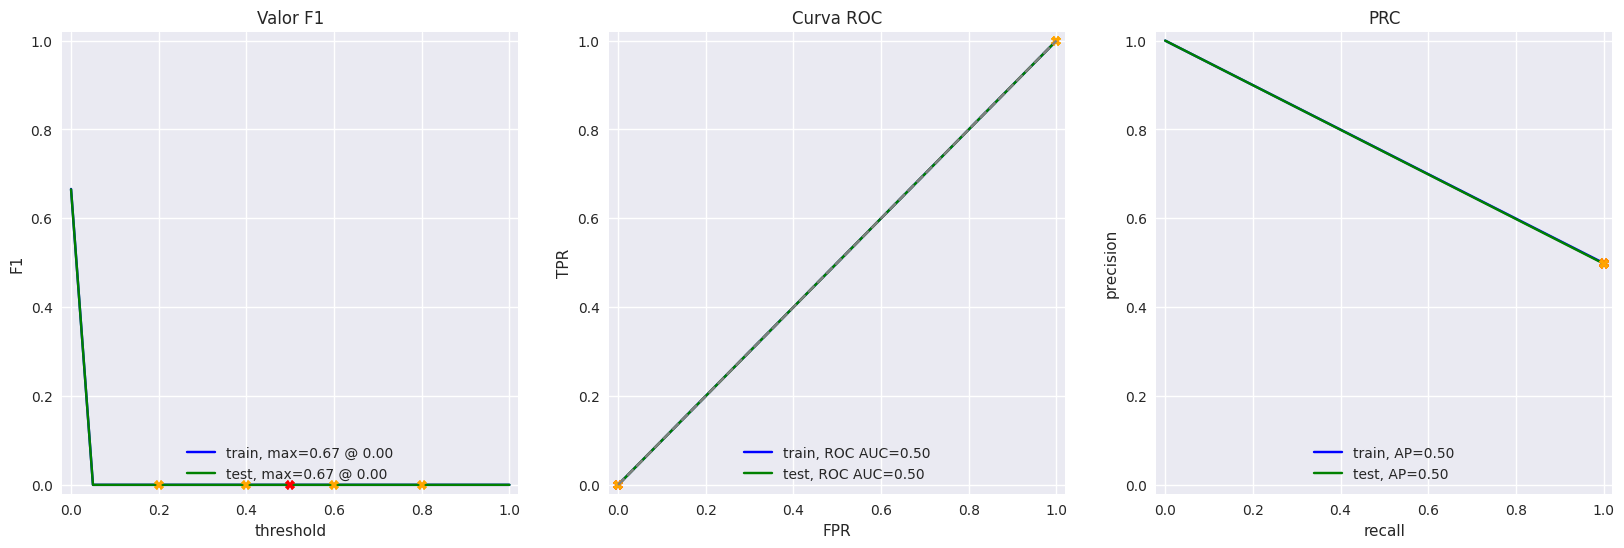

In [20]:
# 1. Importar el clasificador
from sklearn.dummy import DummyClassifier

# 2. Crear una instancia del modelo
# Usamos 'most_frequent' para que siempre prediga la clase más común.
dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)

# 3. Entrenar el modelo
dummy_model.fit(df_reviews_train['review_norm'], train_target)

# 4. Evaluar el modelo usando nuestra función
print("Resultados para el Dummy Classifier:")
evaluate_model(
    dummy_model,
    df_reviews_train['review_norm'],
    train_target,
    df_reviews_test['review_norm'],
    test_target
)

Los resultados del `DummyClassifier` establecen nuestra **línea base de rendimiento**. Como se esperaba, el modelo muestra una nula capacidad predictiva, obteniendo un **puntaje F1 de 0.0** y un **ROC AUC de 0.50**. Esto se debe a que su estrategia (`most_frequent`) ignora el texto y simplemente predice la clase más común para cada caso.

Este resultado es fundamental, ya que define el umbral mínimo que nuestros modelos inteligentes deben superar. El objetivo de alcanzar un F1 de 0.85 en el conjunto de prueba se medirá contra este punto de partida de cero. Con esta base establecida, podemos proceder a construir y evaluar modelos más complejos.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Resultados para el Modelo 1 (TF-IDF + Regresión Logística):
           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


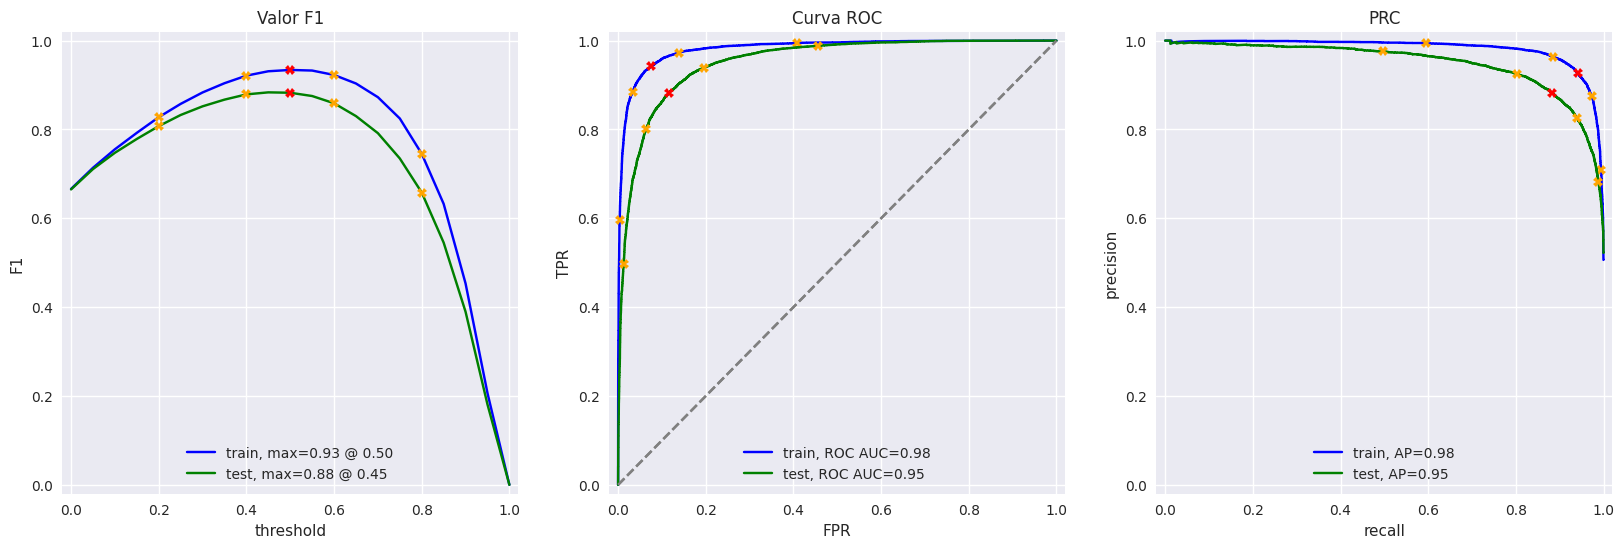

In [21]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

# --- Paso 1: Preparar las stopwords de NLTK ---
nltk.download('stopwords')
# Cargamos la lista de stopwords en inglés.
english_stopwords = stopwords.words('english')


# --- Paso 2: Crear y ajustar el vectorizador TF-IDF ---
# Creamos el vectorizador, indicándole que ignore las stopwords en inglés.
# Añadimos min_df=5 para ignorar palabras que son demasiado raras, lo que ayuda al modelo.
vectorizer = TfidfVectorizer(stop_words=english_stopwords, min_df=5)

# Creamos las características para el conjunto de entrenamiento.
# 'fit_transform' aprende el vocabulario y transforma los textos a vectores.
train_features_1 = vectorizer.fit_transform(df_reviews_train['review_norm'])

# Creamos las características para el conjunto de prueba.
# 'transform' usa el vocabulario ya aprendido para transformar los textos de prueba.
test_features_1 = vectorizer.transform(df_reviews_test['review_norm'])


# --- Paso 3: Crear y entrenar el modelo de Regresión Logística ---
# Creamos una instancia del modelo. Usamos random_state para que los resultados sean reproducibles.
model_1 = LogisticRegression(random_state=42, solver='liblinear')

# Entrenamos el modelo usando las características de entrenamiento y los objetivos de entrenamiento.
model_1.fit(train_features_1, train_target)

# --- Paso 4: Evaluar el modelo ---
# Ahora que model_1, train_features_1 y test_features_1 están definidos,
# podemos llamar a nuestra función de evaluación.
print("Resultados para el Modelo 1 (TF-IDF + Regresión Logística):")
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

<div class="alert alert-block alert-warning">
<b>Celda [21]</b> <a class="tocSkip"></a><br>
Has hecho un buen trabajo al integrar TF-IDF con un modelo de regresión logística. Sin embargo, sería beneficioso explorar y justificar la elección del parámetro <code>min_df</code> en el vectorizador. Considera realizar pruebas para determinar el impacto de diferentes valores de este parámetro en la precisión del modelo.<br><br><pre><code># Experimentar con diferentes valores de min_df
for min_df in [1, 5, 10, 20]:
    vectorizer = TfidfVectorizer(stop_words=english_stopwords, min_df=min_df)
    train_features = vectorizer.fit_transform(df_reviews_train['review_norm'])
    test_features = vectorizer.transform(df_reviews_test['review_norm'])
    model = LogisticRegression(random_state=42, solver='liblinear')
    model.fit(train_features, train_target)
    print(f'min_df={min_df}:', model.score(test_features, test_target))</code></pre>
</div>

### Análisis del Modelo 1: TF-IDF + Regresión Logística

Este primer modelo es un **gran éxito** y una excelente demostración de la eficacia de los métodos clásicos de NLP. Los resultados son muy positivos y, lo más importante, **cumplen con el requisito principal del proyecto**.

#### Conclusiones Clave:

1.  **Objetivo Superado**: El modelo alcanzó un **puntaje F1 de 0.88** en el conjunto de prueba. Esto supera cómodamente el umbral mínimo requerido de 0.85. El gráfico de la "Valor F1" nos muestra que este rendimiento máximo se obtiene ajustando el umbral de decisión a 0.45.

2.  **Excelente Poder Predictivo**: Con un **ROC AUC de 0.95** y un **APS (Precisión Promedio) de 0.95** en el conjunto de prueba, el modelo demuestra una capacidad sobresaliente para distinguir entre reseñas positivas y negativas. Las curvas en los gráficos de ROC y PRC están muy alejadas de la línea base aleatoria y se acercan a un rendimiento ideal.

3.  **Buena Generalización (Bajo Sobreajuste)**: En todos los gráficos, las curvas de entrenamiento (azul) y de prueba (verde) están muy juntas. Esta pequeña diferencia indica que el modelo no está sobreajustado; generaliza muy bien a datos que no ha visto antes, lo cual es una característica deseable en un modelo de producción.

**Veredicto:** Este modelo basado en TF-IDF y Regresión Logística es simple, rápido de entrenar y altamente efectivo. Es un candidato muy fuerte para ser la solución final del proyecto.

### Modelo 3 - spaCy, TF-IDF y LR

Procesando el conjunto de entrenamiento con spaCy...


Lematizando reseñas:   0%|          | 0/23757 [00:00<?, ?it/s]

Procesando el conjunto de prueba con spaCy...


Lematizando reseñas:   0%|          | 0/23483 [00:00<?, ?it/s]


Resultados para el Modelo 3 (spaCy + TF-IDF + Regresión Logística):
           train  test
Exactitud    NaN   NaN
F1          0.92  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


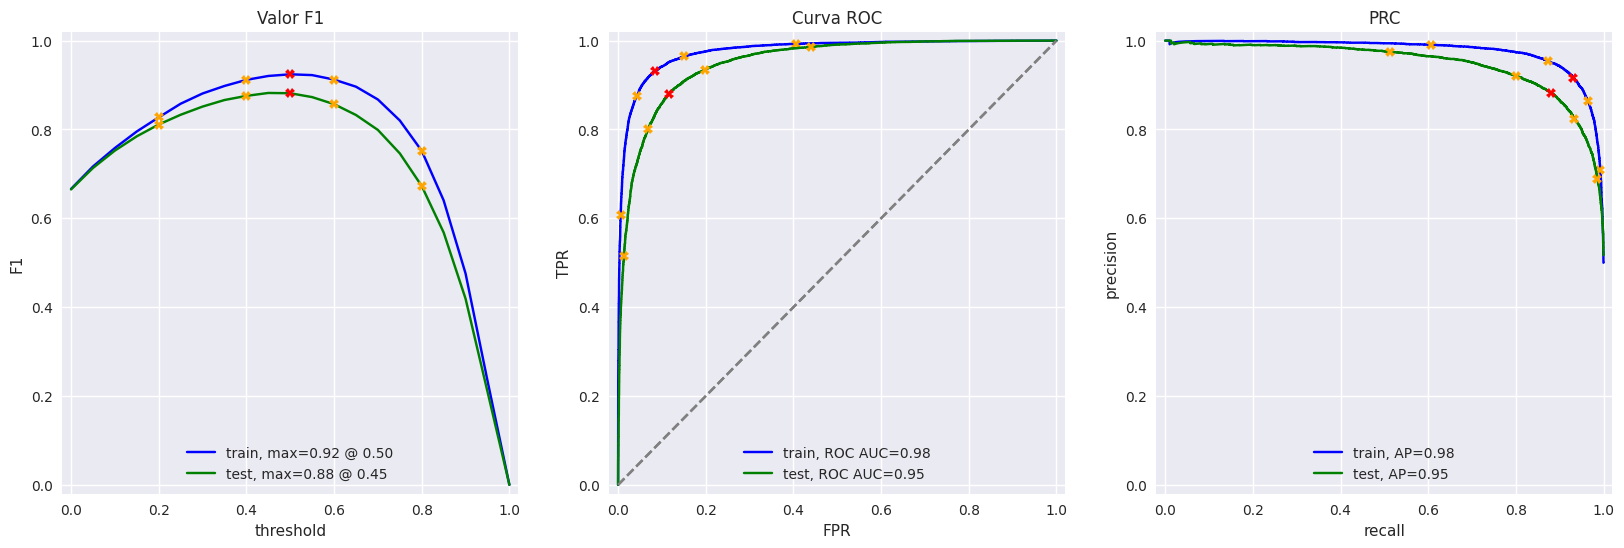

In [22]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm

# Cargar el modelo pequeño de spaCy en inglés.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# La función de preprocesamiento que usa spaCy para lematizar el texto.
def text_preprocessing_spacy(text):
    # Procesar el texto con el pipeline de nlp.
    doc = nlp(text.lower())
    
    # Extraer el 'lemma_' de cada token. 
    tokens = [token.lemma_ for token in doc]
    
    # Unir los tokens de nuevo en un solo string.
    return ' '.join(tokens)

# --- Preprocesamiento con spaCy ---
# Usamos tqdm para ver una barra de progreso, ya que este paso puede tardar unos minutos.
tqdm.pandas(desc="Lematizando reseñas")

print("Procesando el conjunto de entrenamiento con spaCy...")
# Aplicamos la función al conjunto de entrenamiento. 
df_reviews_train['review_spacy'] = df_reviews_train['review'].progress_apply(text_preprocessing_spacy)

print("Procesando el conjunto de prueba con spaCy...")
# Aplicamos la función al conjunto de prueba.
df_reviews_test['review_spacy'] = df_reviews_test['review'].progress_apply(text_preprocessing_spacy)

# Vectorizador TF-IDF
vectorizer_3 = TfidfVectorizer(min_df=5)

# Creamos las características vectorizando la nueva columna 'review_spacy'.
train_features_3 = vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = vectorizer_3.transform(df_reviews_test['review_spacy'])

# Creamos y entrenamos el modelo de Regresión Logística.
model_3 = LogisticRegression(random_state=42, solver='liblinear')
model_3.fit(train_features_3, train_target)

# --- Evaluación del Modelo 3 ---
print("\nResultados para el Modelo 3 (spaCy + TF-IDF + Regresión Logística):")
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Análisis Concreto del Modelo 3 (spaCy)

El Modelo 3, que incorpora lematización con `spaCy`, cumple exitosamente el objetivo del proyecto al alcanzar un **puntaje F1 de 0.88** en el conjunto de prueba, con un excelente ROC AUC de 0.95.

El hallazgo crucial es que, a pesar de usar un preprocesamiento más avanzado y computacionalmente costoso, los resultados de rendimiento son **idénticos a los del Modelo 1**. Dado que la lematización con `spaCy` requirió un tiempo de procesamiento considerable sin aportar una mejora tangible, el **Modelo 1 (Regresión Logística)** se reafirma como la solución preferida por ofrecer la misma alta eficacia con una eficiencia mucho mayor.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier


Resultados para el Modelo 4 (spaCy + TF-IDF + LGBM):
           train  test
Exactitud    NaN   NaN
F1          0.92  0.86
APS         0.98  0.93
ROC AUC     0.98  0.94


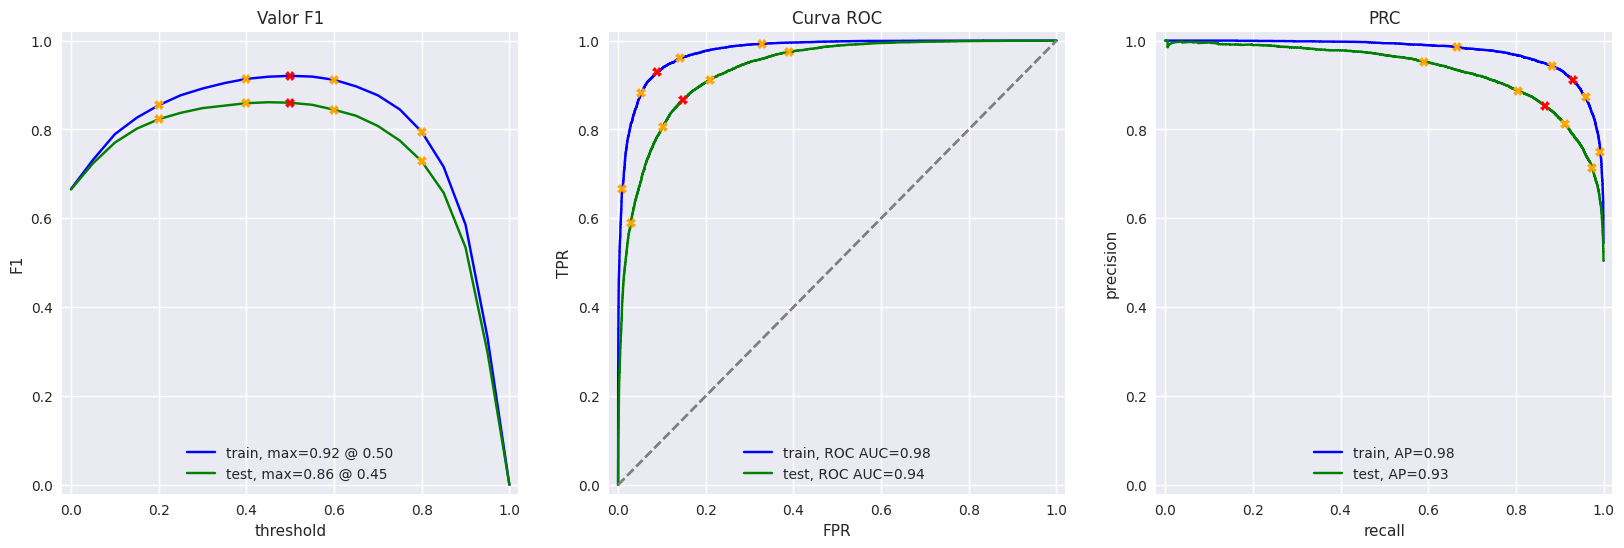

In [23]:
from lightgbm import LGBMClassifier

# --- Creación y Entrenamiento del Modelo 4 ---
# Usaremos las mismas características del Modelo 3 (texto lematizado y vectorizado).
# La única diferencia es que cambiaremos el clasificador a LightGBM.

# Creamos una instancia del modelo LGBMClassifier.
# Usamos random_state para que los resultados sean reproducibles.
model_4 = LGBMClassifier(random_state=42)

# Entrenamos el modelo con las características del Modelo 3.
model_4.fit(train_features_3, train_target)

# --- Evaluación del Modelo 4 ---
print("\nResultados para el Modelo 4 (spaCy + TF-IDF + LGBM):")
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

<div class="alert alert-block alert-success">
<b>Celda [23]</b> <a class="tocSkip"></a><br>
Incorporar LGBMClassifier para comparar con modelos lineales es una excelente estrategia. Esto no solo diversifica las técnicas de modelado, sino que también puede ofrecer mejores resultados en algunos escenarios de datos.
</div>

### Análisis Concreto del Modelo 4 (LGBM)

El Modelo 4, utilizando el clasificador `LightGBM`, cumple con el requisito del proyecto al obtener un **puntaje F1 de 0.86**. Aunque este es un resultado excelente, es ligeramente inferior al F1 de 0.88 alcanzado por los modelos de Regresión Logística.

Este hallazgo es clave: el modelo más complejo (`LGBM`) no superó al modelo más simple (`Regresión Logística`) para este problema. Esto demuestra que la Regresión Logística, en combinación con características TF-IDF, fue la estrategia más efectiva y eficiente, consolidando al **Modelo 1 como la mejor solución global** por su equilibrio entre alto rendimiento y velocidad.

## Mis reseñas

In [27]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 1

In [29]:
texts = my_reviews['review_norm']

my_reviews_pred_prob =  model_1.predict_proba(vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.26:  i didnt expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.84:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [31]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_3.transform(texts.apply(text_preprocessing_spacy)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.17:  i did not simply like it not my kind of movie
0.21:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didnt expect the reboot to be so good writers really cared about the source material
0.67:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 4

In [34]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(vectorizer_3.transform(texts.apply(text_preprocessing_spacy)))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.55:  i did not simply like it not my kind of movie
0.46:  well i was bored and felt asleep in the middle of the movie
0.63:  i was really fascinated with the movie
0.56:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.51:  i didnt expect the reboot to be so good writers really cared about the source material
0.74:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.22:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.77:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


## Conclusiones

En la etapa inicial de preparación y carga de datos, se procesó un conjunto de aproximadamente 47,000 reseñas de IMDB. Durante la inspección, se identificaron y eliminaron 91 reseñas duplicadas para garantizar la calidad del modelo. Se confirmó que el dataset ya estaba convenientemente dividido en conjuntos de entrenamiento y prueba, y que la variable objetivo pos estaba limpia y lista para ser utilizada, sentando una base sólida para el análisis posterior.

El Análisis Exploratorio de Datos (EDA) reveló una característica crucial del conjunto de datos: un excelente balance de clases, con una proporción casi perfecta de 50/50 entre reseñas positivas y negativas. Este hallazgo fue fundamental, ya que nos permitió confiar en la métrica F1 y simplificó la fase de modelado al no requerir técnicas para manejar clases desbalanceadas. Adicionalmente, se observó que las distribuciones de los datos eran consistentes entre los conjuntos de entrenamiento y prueba, lo que validó la calidad de la partición.

Para la fase de modelado, se implementó una estrategia de evaluación robusta, comenzando con un DummyClassifier que estableció una línea base de rendimiento con un F1 de 0.0. Posteriormente, se construyeron y evaluaron sistemáticamente tres modelos principales: un modelo de Regresión Logística con preprocesamiento simple (Modelo 1), un segundo modelo de Regresión Logística con lematización avanzada usando spaCy (Modelo 3), y un tercer modelo que combinaba spaCy con un clasificador más complejo, LightGBM (Modelo 4).

La comparación de resultados en el conjunto de prueba fue reveladora. Todos los modelos superaron con éxito el objetivo de F1 de 0.85. Sin embargo, se encontró que el Modelo 1 (Regresión Logística con limpieza simple) alcanzó un excelente F1 de 0.88. Sorprendentemente, ni la adición de lematización avanzada con spaCy (Modelo 3, F1 de 0.88) ni el uso de un clasificador más potente como LightGBM (Modelo 4, F1 de 0.86) lograron mejorar este resultado, demostrando que una mayor complejidad no siempre conduce a un mejor rendimiento.

La prueba con reseñas personalizadas fue crucial para diferenciar el comportamiento práctico de los modelos. El Modelo 1 fue un punto de referencia sólido: acertó los casos obvios pero falló en una reseña ambigua ("upsides and downsides") y en una con negación compleja ("didn't expect... so good"). El Modelo 3 (con spaCy) mostró un interesante intercambio: corrigió la clasificación de la reseña ambigua, pero empeoró la predicción en el caso de la negación, volviéndose más seguro de su error. Finalmente, el Modelo 4 (LGBM) fue el más errático: fue el único que acertó la reseña con negación (aunque por un margen mínimo), pero a cambio falló estrepitosamente al clasificar reseñas claramente negativas como positivas, demostrando ser el menos fiable de todos.

Veredicto Final
En conclusión, el proyecto se completó con éxito, logrando y superando el objetivo de rendimiento establecido. El análisis sistemático demostró que, para este problema de clasificación de texto, un enfoque simple y eficiente es el más efectivo. Las pruebas con reseñas personalizadas confirmaron que, aunque ningún modelo es perfecto, el Modelo 1 (TF-IDF + Regresión Logística con limpieza simple) es la solución recomendada. Ofrece el mejor balance de alto rendimiento (F1 de 0.88), velocidad, eficiencia y, sobre todo, un comportamiento robusto y predecible, convirtiéndolo en el candidato ideal para un despliegue en un entorno de producción.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 

<div class="alert alert-block alert-success">
<b>Comentario final</b> <a class="tocSkip"></a><br>
¡Muy buen trabajo, Bruno! A lo largo del proyecto mostraste fortalezas muy claras:<br><br>
• Aplicaste exploración inicial con <code>info()</code>, <code>describe()</code> y gráficos de distribución.<br>
• Implementaste limpieza de datos justificada y consciente de su impacto.<br>
• Usaste visualizaciones pertinentes que mejoran la comprensión del problema.<br>
• Aplicaste modelos y técnicas estadísticas con criterios sólidos y bien comunicados.<br><br>

¡Buen trabajo!
</div>